In [9]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
from tqdm import tqdm
from collections import deque
import os
import gc

In [10]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=50, num_boost_round=8000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 16,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=50, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)

def get_category(load=True,data=None):
    
    if os.path.exists('../input/X_category.csv') and load:
        print 'load... X_category'
        X_category = pd.read_csv('../input/X_category.csv')
        data['category'] = X_category
    else:
        print 'save... X_category'
        D=2**32
        data['category'] = (data['ip'].astype(str) + "_" + data['app'].astype(str) + "_" + data['device'].astype(str) \
            + "_" + data['os'].astype(str)).apply(hash) % D
        data['category'].to_csv('../input/X_category.csv',index=False,header=True)
    return True
    
def get_agg(agg_features=['ip'],target='is_attributed',aggfunc=np.mean,load=True, data = None,\
            len_train = None,encoding_for_val = False,len_val = None):
    
    if type(aggfunc)!=str:
        filename='X_'+'_'.join(agg_features)+'_'+str(aggfunc.func_name)+ '_' + target
    else:
        filename='X_'+'_'.join(agg_features)+'_'+str(aggfunc)+ '_'+target
        
    gp = []
    if os.path.exists('../input/'+filename+'for_val.csv') and load and encoding_for_val and 'is_attributed' in filename:     #label encoding for val
        print 'load...'+filename+'for_val'
        gp=pd.read_csv('../input/'+filename+'for_val.csv',index_col=None).values
        data[filename]=gp
    elif os.path.exists('../input/'+filename+'.csv') and load:                               #label encoding for test
        print 'load...'+filename
        gp=pd.read_csv('../input/'+filename+'.csv',index_col=None).values
        data[filename]=gp
    else:
        print 'save...'+filename
        if 'cumcount' == aggfunc:
            gp=data.groupby(agg_features)[target].cumcount().values
            data[filename]=gp
            data[filename].to_csv('../input/'+filename+'.csv',index=False,header=True)
        if 'is_attributed' == target:
            if len(agg_features) == 1:
                if encoding_for_val:
                    print filename + 'for_val'
                    gp=data[agg_features[-1]].map(data[:len_train-len_val].groupby(agg_features[-1])[target].agg(aggfunc)).values
                    data[filename]=gp
                    data[filename].to_csv('../input/'+filename+'for_val.csv',index=False,header=True)
                else:
                    print filename 
                    gp=data[agg_features[-1]].map(data[:len_train].groupby(agg_features[-1])[target].agg(aggfunc)).values                    
                    data[filename]=gp
                    data[filename].to_csv('../input/'+filename+'.csv',index=False,header=True)   
            else:
                if encoding_for_val:
                    print 'groupby...'+filename + 'for_val'
                    gp = data[:len_train-len_val].groupby(agg_features)[target].agg(aggfunc).reset_index().\
                            rename(index=str, columns={target: filename})
                    data = data.merge(gp, on=agg_features, how='left')
                    data[filename].to_csv('../input/'+filename+'for_val.csv',index=False,header=True)
                else:
                    print 'groupby...'+filename
                    gp = data[:len_train].groupby(agg_features)[target].agg(aggfunc).reset_index().\
                            rename(index=str, columns={target: filename})
                    data = data.merge(gp, on=agg_features, how='left')
                    data[filename].to_csv('../input/'+filename+'.csv',index=False,header=True)                
        else:
            if len(agg_features) == 1:
                print filename 
                gp=data[agg_features[-1]].map(data.groupby(agg_features[-1])[target].agg(aggfunc)).values
                data[filename]=gp
                data[filename].to_csv('../input/'+filename+'.csv',index=False,header=True)   
            else:
                print 'groupby...'+filename
                gp = data.groupby(agg_features)[target].agg(aggfunc).reset_index().\
                        rename(index=str, columns={target: filename})
                data = data.merge(gp, on=agg_features, how='left')
                data[filename].to_csv('../input/'+filename+'.csv',index=False,header=True)
    
    return data

def get_next_clicktime(agg_feature='category',target_feature='click_time', load=True, data=None):
    filename = 'X_'+agg_feature+'_'+target_feature+'_nextclicktime'
    pre_list = []
    if os.path.exists('../input/'+filename+'.csv') and load:
        pre_list=pd.read_csv('../input/'+filename+'.csv',index_col=None).values
    else:
        tmp = data[['category','click_time']]
        tmp = tmp.values
        mp = {}
        pre_list = []
        for i in tqdm(range(tmp.shape[0]-1,-1,-1)):
            user_id,timestamp = tmp[i]
            if not user_id in mp:
                mp[user_id] = timestamp
                pre_list.append(0)
                continue
            q=mp[user_id]
            pre_list.append(q-timestamp)
            mp[user_id] = timestamp
        pre_list.reverse()
        
        pd.DataFrame(pre_list,columns=[filename]).to_csv('../input/'+filename+'.csv',index=False,header=True)
    
    data[filename] = pre_list
    
    return True

                
def get_last_cnt(agg_feature='category',target_feature='click_time', hour=2, load=True, data=None):
    
    filename = 'X_'+agg_feature+'_'+target_feature+'_last_hour_'+str(hour)
    pre_list = []
    if os.path.exists('../input/'+filename+'.csv') and load:
        pre_list=pd.read_csv('../input/'+filename+'.csv',index_col=None).values
    else:
        tmp = data[['category','click_time']]
        tmp = tmp.values
        mp = {}
        pre_list = []
        for i in tqdm(range(tmp.shape[0]-1,-1,-1)):
            user_id,timestamp = tmp[i]
            if not user_id in mp:
                mp[user_id] = deque([])
                mp[user_id].append(timestamp)
                pre_list.append(0)
                continue
            q=mp[user_id]
            q.append(timestamp)
            while (len(q)>0 and (q[0]-timestamp)>hour*3600): 
                q.pop()
            pre_list.append(int(len(q)))
        
        pre_list.reverse()
        
        pd.DataFrame(pre_list,columns=[filename]).to_csv('../input/'+filename+'.csv',index=False,header=True)
    
    data[filename] = pre_list
    
    return True


def get_pre_cnt(agg_feature='category',target_feature='click_time', hour=2, load=True, data=None):
    filename = 'X_'+agg_feature+'_'+target_feature+'_pre_hour_'+str(hour)
    pre_list = []
    if os.path.exists('../input/'+filename+'.csv') and load:
        pre_list=pd.read_csv('../input/'+filename+'.csv',index_col=None).values
    else:
        tmp = data[['category','click_time']]
        tmp = tmp.values
        mp = {}
        pre_list = []
        for i in tqdm(range(tmp.shape[0])):
            user_id,timestamp = tmp[i]
            if not user_id in mp:
                mp[user_id] = deque([])
                mp[user_id].append(timestamp)
                pre_list.append(0)
                continue
            q=mp[user_id]
            while (len(q)!=0 and timestamp-q[0]>hour*3600): 
                q.pop()
            pre_list.append(int(len(q)))
            q.append(timestamp)        
        pd.DataFrame(pre_list,columns=[filename]).to_csv('../input/'+filename+'.csv',index=False,header=True)
    
    data[filename] = pre_list
    
    return True

In [11]:
def DO(frm,to,fileno,bst_rounds=800):
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32',
            }
    
    print('loading train data...',frm,to)
    data = pd.read_csv("../input/train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes,
                       usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

    print('loading all test data...')
    test_df = pd.read_csv("../input/test_supplement.csv", parse_dates=['click_time'], dtype=dtypes, 
                          usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    
    print data.shape,test_df.shape
        
    len_train = len(data)
    data=data.append(test_df)
    del test_df
    gc.collect()
    
    print('Extracting new features...')
    data['hour'] = pd.to_datetime(data.click_time).dt.hour.astype('uint8')
    data['day'] = pd.to_datetime(data.click_time).dt.day.astype('uint8')
    
    len_val = (data[:len_train].day==9).sum()
    print(len_train,len_val)
    print('click_time....')
    data['click_time'] = data.click_time.map(lambda x:x.day*24*3600+x.hour*3600+x.minute*60+x.second)
    
    gc.collect()
    
    naddfeat=44
    for i in range(0,9)+range(20,44):    
        if i==0: agg_features,target,aggfunc=(['ip'],'channel',pd.Series.nunique);
        if i==1: agg_features,target,aggfunc=(['ip','device','os',],'app','cumcount');
        if i==2: agg_features,target,aggfunc=(['ip','day'],'hour',pd.Series.nunique);
        if i==3: agg_features,target,aggfunc=(['ip'],'app',pd.Series.nunique);
        if i==4: agg_features,target,aggfunc=(['ip','app'],'os',pd.Series.nunique);
        if i==5: agg_features,target,aggfunc=(['ip'],'device',pd.Series.nunique);
        if i==6: agg_features,target,aggfunc=(['app'],'channel',pd.Series.nunique);
        if i==7: agg_features,target,aggfunc=(['ip'],'os','cumcount');
        if i==8: agg_features,target,aggfunc=(['ip','device','os'],'app',pd.Series.nunique);
        
        ####### target-category encoding
        #if i==9: agg_features,target,aggfunc=(['ip'],'is_attributed',np.mean);
        #if i==10: agg_features,target,aggfunc=(['device'],'is_attributed',np.mean);
        #if i==11: agg_features,target,aggfunc=(['os'], 'is_attributed',np.mean);
        #if i==12: agg_features,target,aggfunc=(['app'], 'is_attributed', np.mean);
        #if i==13: agg_features,target,aggfunc=(['channel'],'is_attributed',np.mean);
        #if i==14: agg_features,target,aggfunc=(['hour'],'is_attributed',np.mean);
        ##if i==13: agg_features,target,aggfunc=(['ip','device'],'is_attributed',np.mean);
        ##if i==14: agg_features,target,aggfunc=(['ip','os'],'is_attributed',np.mean);
        ##if i==15: agg_features,target,aggfunc=(['ip','app'],'is_attributed',np.mean);
        #if i==15: agg_features,target,aggfunc=(['os','app'],'is_attributed',np.mean);
        #if i==16: agg_features,target,aggfunc=(['os','channel'],'is_attributed',np.mean);
        #if i==17: agg_features,target,aggfunc=(['os','device'],'is_attributed',np.mean);
        #if i==18: agg_features,target,aggfunc=(['device','app'],'is_attributed',np.mean);
        #if i==19: agg_features,target,aggfunc=(['device','channel'],'is_attributed',np.mean);
            
            
        ###### kernel 2 features######
        if i==20: agg_features,target,aggfunc=(['ip','day','channel'],'hour',np.var);
        if i==21: agg_features,target,aggfunc=(['ip','app','os'],'hour',np.var);
        if i==22: agg_features,target,aggfunc=(['ip','app','channel'],'day',np.var);
        if i==23: agg_features,target,aggfunc=(['ip','app','channel'],'hour',np.mean); 
            
        if i==24: agg_features,target,aggfunc=(['ip'],'channel',np.size); 
        if i==25: agg_features,target,aggfunc=(['device'],'channel',np.size); 
        if i==26: agg_features,target,aggfunc=(['os'],'channel',np.size); 
        if i==27: agg_features,target,aggfunc=(['channel'],'ip',np.size); 
            
        if i==28: agg_features,target,aggfunc=(['ip','app'],'channel',np.size);
        if i==29: agg_features,target,aggfunc=(['ip','hour'],'channel',np.size); 
        if i==30: agg_features,target,aggfunc=(['ip','device'],'channel',np.size);
            
        if i==31: agg_features,target,aggfunc=(['channel','hour'],'ip',np.size); 
        if i==32: agg_features,target,aggfunc=(['channel','app'],'ip',np.size); 
        if i==33: agg_features,target,aggfunc=(['channel','ip'],'app',np.size); 
        if i==34: agg_features,target,aggfunc=(['app','hour'],'channel',np.size); 
        if i==35: agg_features,target,aggfunc=(['device','hour'],'channel',np.size); 
            
        if i==36: agg_features,target,aggfunc=(['app','os','channel'],'device',np.size); 
        if i==37: agg_features,target,aggfunc=(['ip','day','hour'], 'channel', np.size);
        if i==38: agg_features,target,aggfunc=(['ip','app','os'],'channel',np.size);
            
        if i==39: agg_features,target,aggfunc=(['os','ip','app','hour'],'channel',np.size); 
        if i==40: agg_features,target,aggfunc=(['os','ip','app','day'],'channel',np.size); 
        if i==41: agg_features,target,aggfunc=(['os','ip','channel','hour'],'app',np.size); 
        if i==42: agg_features,target,aggfunc=(['device','ip','channel','hour'],'app',np.size); 
        if i==43: agg_features,target,aggfunc=(['os','ip','channel','day'],'app',np.size); 
        
        
        get_agg(agg_features,target,aggfunc,load=True,data=data,len_train=len_train,encoding_for_val = val,len_val = len_val)
        gc.collect()
        
    get_category(load=False,data=data)
    
    get_next_clicktime(load=False,data=data)
    get_last_cnt(load=False,hour=2.0,data=data)
    get_pre_cnt(load=False,hour=2.0,data=data)
    get_last_cnt(load=False,hour=.1,data=data)
    get_pre_cnt(load=False,hour=0.1,data=data)
    get_last_cnt(load=False,hour=0.5,data=data)
    get_pre_cnt(load=False,hour=0.5,data=data)
    get_last_cnt(load=False,hour=1.0,data=data)
    get_pre_cnt(load=False,hour=1.0,data=data)
     
    predictors = [item for item in data.columns if item not in ['category','is_attributed','click_id','click_time']]
    target ='is_attributed'
    categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']

    test_df = data[len_train:]
    data = data[:len_train]
    
    
    val_df = data[data.day==9]
    if val:
        data = data[data.day<9]

    print("train size: ", len(data))
    print("valid size: ", len(val_df))
    print("test size : ", len(test_df))

    sub = pd.DataFrame()
    sub['click_id'] = test_df['click_id'].astype('int')

    sub_val =pd.DataFrame()
    sub_val['click_id']=val_df.index.values
    
    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.06,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200, # because training data is extremely unbalanced 
        'nthread': 16,
    }
    
    _num_boost_round=5000
    if not val:
        _num_boost_round=bst_rounds
        
    (bst,best_iteration) = lgb_modelfit_nocv(params, 
                            data, 
                            val_df, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=50, 
                            verbose_eval=True, 
                            num_boost_round=_num_boost_round, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    if val:
        print("Predicting VAL...")
        sub_val['is_attributed'] = bst.predict(val_df[predictors],num_iteration=best_iteration)
        print("writing...")
        sub_val.to_csv('../sub/sub34_val_it%d.csv.gz'%(fileno),index=False,compression='gzip')
    print("done...")        
    del data
    del val_df
    gc.collect()
    
    print('Plot feature importances...')
    ax = lgb.plot_importance(bst, max_num_features=100)
    plt.show()
    if not val:
        print("Predicting...")
        sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
        print("writing...")
        sub.to_csv('../sub/sub34_alltest_it%d.csv.gz'%(fileno),index=False,compression='gzip')
    print("done...")
    return sub,best_iteration

('loading train data...', 0, 184903890)
loading all test data...
(184903890, 7) (57537505, 7)
Extracting new features...
(184903890, 53016937)
click_time....
load...X_ip_nunique_channel
load...X_ip_device_os_cumcount_app
load...X_ip_day_nunique_hour
load...X_ip_nunique_app
load...X_ip_app_nunique_os
load...X_ip_nunique_device
load...X_app_nunique_channel
load...X_ip_cumcount_os
load...X_ip_device_os_nunique_app
load...X_ip_day_channel_var_hour
load...X_ip_app_os_var_hour
load...X_ip_app_channel_var_day
load...X_ip_app_channel_mean_hour
load...X_ip_size_channel
load...X_device_size_channel
load...X_os_size_channel
load...X_channel_size_ip
load...X_ip_app_size_channel
load...X_ip_hour_size_channel
load...X_ip_device_size_channel
load...X_channel_hour_size_ip
load...X_channel_app_size_ip
load...X_channel_ip_size_app
load...X_app_hour_size_channel
load...X_device_hour_size_channel
load...X_app_os_channel_size_device
load...X_ip_day_hour_size_channel
load...X_ip_app_os_size_channel
load...X

/home/t-zhga/gzf-env/local/lib/python2.7/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.979206	valid's auc: 0.975181
[100]	train's auc: 0.983252	valid's auc: 0.980015
[150]	train's auc: 0.984842	valid's auc: 0.981541
[200]	train's auc: 0.985599	valid's auc: 0.982157
[250]	train's auc: 0.986119	valid's auc: 0.982559
[300]	train's auc: 0.986511	valid's auc: 0.982861
[350]	train's auc: 0.986783	valid's auc: 0.983045
[400]	train's auc: 0.987021	valid's auc: 0.983186
[450]	train's auc: 0.987204	valid's auc: 0.983272
[500]	train's auc: 0.987388	valid's auc: 0.983358
[550]	train's auc: 0.987536	valid's auc: 0.983399
[600]	train's auc: 0.987678	valid's auc: 0.983444
[650]	train's auc: 0.987798	valid's auc: 0.983463
[700]	train's auc: 0.987913	valid's auc: 0.983492
[750]	train's auc: 0.988018	valid's auc: 0.983508
[800]	train's auc: 0.988113	valid's auc: 0.98351
[850]	train's auc: 0.988213	valid's auc: 0.983538
[900]	train's auc: 0.988303	valid's auc: 0.983537
Early stopping, best iteration is:
[861]

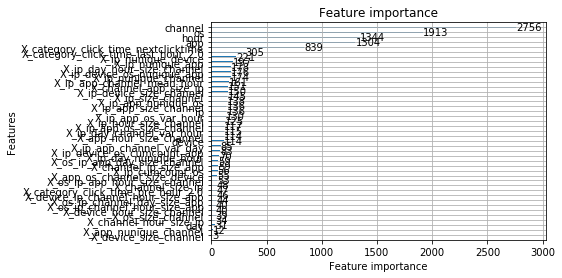

done...


In [12]:
nrows=184903891-1
frm=0
to=nrows
val = 1
sub,_bst_rounds=DO(frm,to,2)

('loading train data...', 0, 184903890)
loading all test data...
(184903890, 7) (57537505, 7)
Extracting new features...
(184903890, 53016937)
click_time....
load...X_ip_nunique_channel
load...X_ip_device_os_cumcount_app
load...X_ip_day_nunique_hour
load...X_ip_nunique_app
load...X_ip_app_nunique_os
load...X_ip_nunique_device
load...X_app_nunique_channel
load...X_ip_cumcount_os
load...X_ip_device_os_nunique_app
load...X_ip_day_channel_var_hour
load...X_ip_app_os_var_hour
load...X_ip_app_channel_var_day
load...X_ip_app_channel_mean_hour
load...X_ip_size_channel
load...X_device_size_channel
load...X_os_size_channel
load...X_channel_size_ip
load...X_ip_app_size_channel
load...X_ip_hour_size_channel
load...X_ip_device_size_channel
load...X_channel_hour_size_ip
load...X_channel_app_size_ip
load...X_channel_ip_size_app
load...X_app_hour_size_channel
load...X_device_hour_size_channel
load...X_app_os_channel_size_device
load...X_ip_day_hour_size_channel
load...X_ip_app_os_size_channel
load...X

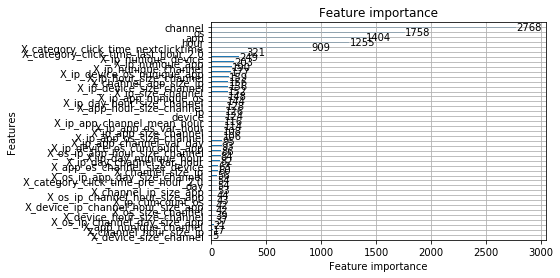

Predicting...
writing...
done...


In [13]:
nrows=184903891-1
frm=0
to=nrows
val = 0
sub=DO(frm,to,2,bst_rounds=_bst_rounds)